
# Calibration Tutorial — Hg / Na (USB2000+)

**Belongs to:** `01_Experiment_Guide/step2_calibration.md`  
**Goal:** Build a wavelength calibration for the Ocean Optics USB2000+ using **Hg** and **Na** emission lines.

> This notebook is a guided *tutorial*. It shows the workflow on **synthetic example data** and provides helper functions.  
> **Your task** is to replace the example data with your own measurements and complete the marked **TODO** cells.



## 🎯 Learning Objectives
- Load and visualize lamp spectra (CSV: wavelength [nm], intensity [counts])
- Detect and fit emission peaks (Gaussian)
- Select reference lines (Hg, Na) and map **pixel → wavelength** or verify **wavelength axis**
- Fit a low-order polynomial calibration and inspect residuals
- Quantify calibration uncertainty and discuss polynomial order


In [1]:

# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from pathlib import Path

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.grid"] = True

print("Libraries loaded.")


Libraries loaded.



## 🧪 Example Data (Synthetic)
We generate **synthetic Hg and Na spectra** with known line positions, sampling and noise.  
Use this to practice the fits, then **replace with your real CSVs**.


In [2]:

# Synthetic spectra generation
rng = np.random.default_rng(42)

def gaussian(x, A, mu, sigma, B):
    return A*np.exp(-(x-mu)**2/(2*sigma**2)) + B

def make_spectrum(wl, lines, widths=0.25, baseline=50, noise=10):
    y = np.full_like(wl, baseline, dtype=float)
    for amp, pos in lines:
        y += gaussian(wl, amp, pos, widths, 0)
    y += rng.normal(0, noise, size=wl.size)
    return y

wl = np.linspace(380, 650, 2048)

hg_lines = [(1800, 404.656), (2200, 435.833), (2500, 546.074), (1800, 577.045), (1700, 579.066)]
na_lines = [(3000, 588.995), (2800, 589.592)]

hg_spectrum = make_spectrum(wl, hg_lines, widths=0.20, baseline=40, noise=12)
na_spectrum = make_spectrum(wl, na_lines, widths=0.18, baseline=40, noise=10)

hg_df = pd.DataFrame({"wavelength_nm": wl, "intensity": hg_spectrum})
na_df = pd.DataFrame({"wavelength_nm": wl, "intensity": na_spectrum})

# Save example CSVs alongside repo structure
data_dir = Path("../05_Data/calibration")
data_dir.mkdir(parents=True, exist_ok=True)
hg_path = data_dir / "Hg_reference_example.csv"
na_path = data_dir / "Na_reference_example.csv"
hg_df.to_csv(hg_path, index=False)
na_df.to_csv(na_path, index=False)

print("Saved:", hg_path.resolve(), "\n       ", na_path.resolve())


Saved: C:\Users\Lucas\05_Data\calibration\Hg_reference_example.csv 
        C:\Users\Lucas\05_Data\calibration\Na_reference_example.csv


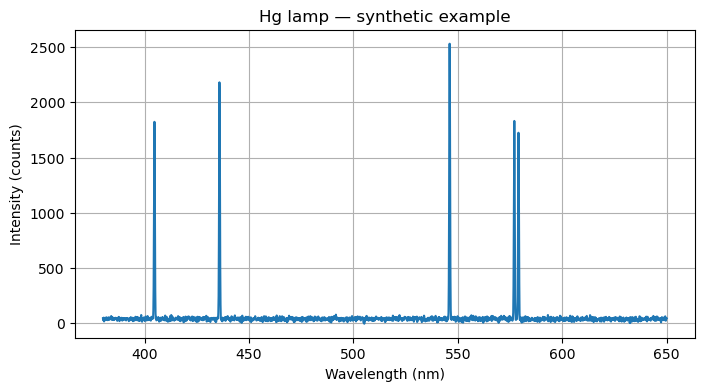

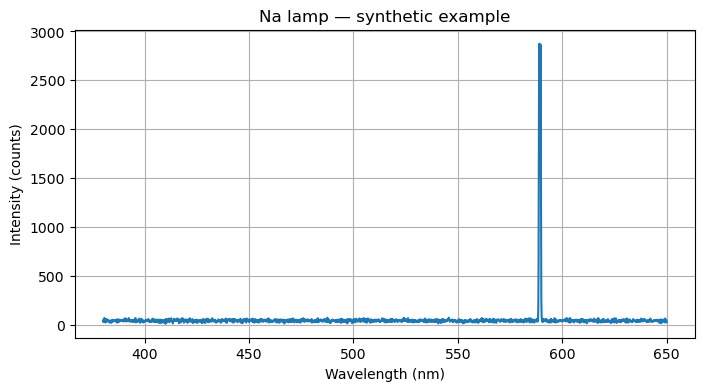

In [3]:

# Quick look plots
fig = plt.figure()
plt.plot(hg_df["wavelength_nm"], hg_df["intensity"])
plt.xlabel("Wavelength (nm)"); plt.ylabel("Intensity (counts)")
plt.title("Hg lamp — synthetic example")
plt.show()

fig = plt.figure()
plt.plot(na_df["wavelength_nm"], na_df["intensity"])
plt.xlabel("Wavelength (nm)"); plt.ylabel("Intensity (counts)")
plt.title("Na lamp — synthetic example")
plt.show()



## 🔍 Peak Detection
Use `scipy.signal.find_peaks`. Adjust `prominence`/`distance` for your data.


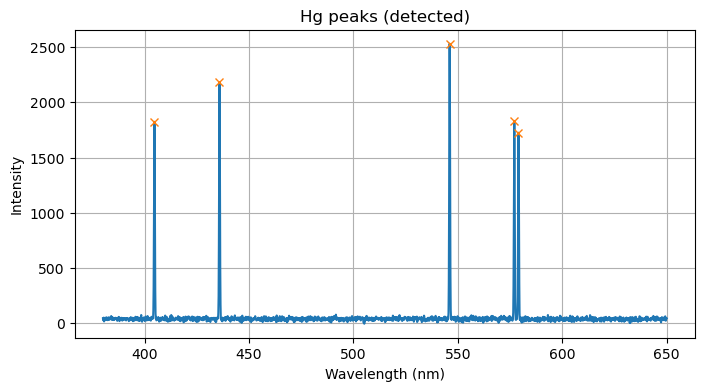

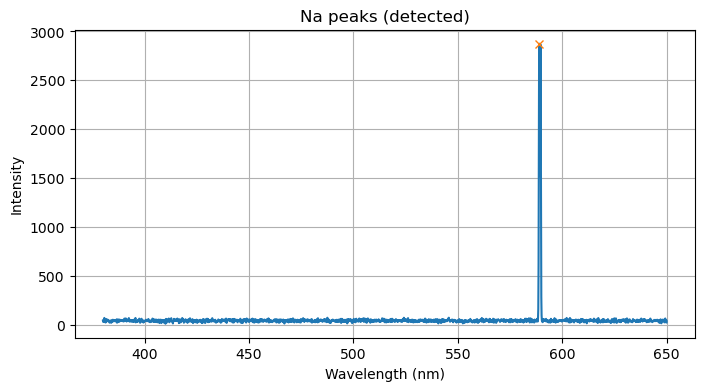

Hg peak candidates: [404.66536395 435.79384465 546.06253053 577.05911089 579.03761602]
Na peak candidates: [589.06204201]


In [4]:

def detect_peaks(wl, y, prominence=100, distance=5):
    idx, props = find_peaks(y, prominence=prominence, distance=distance)
    return idx, props

hg_idx, _ = detect_peaks(hg_df["wavelength_nm"].values, hg_df["intensity"].values, prominence=200, distance=8)
na_idx, _ = detect_peaks(na_df["wavelength_nm"].values, na_df["intensity"].values, prominence=150, distance=8)

plt.figure()
plt.plot(hg_df["wavelength_nm"], hg_df["intensity"])
plt.plot(hg_df["wavelength_nm"].values[hg_idx], hg_df["intensity"].values[hg_idx], "x")
plt.title("Hg peaks (detected)"); plt.xlabel("Wavelength (nm)"); plt.ylabel("Intensity"); plt.show()

plt.figure()
plt.plot(na_df["wavelength_nm"], na_df["intensity"])
plt.plot(na_df["wavelength_nm"].values[na_idx], na_df["intensity"].values[na_idx], "x")
plt.title("Na peaks (detected)"); plt.xlabel("Wavelength (nm)"); plt.ylabel("Intensity"); plt.show()

print("Hg peak candidates:", hg_df['wavelength_nm'].values[hg_idx])
print("Na peak candidates:", na_df['wavelength_nm'].values[na_idx])



## 🧰 Peak Fitting (Gaussian)
Fit a **Gaussian + baseline** to a small window around each peak.

> **TODO:** Decide which peaks to keep/exclude (blends, low SNR).


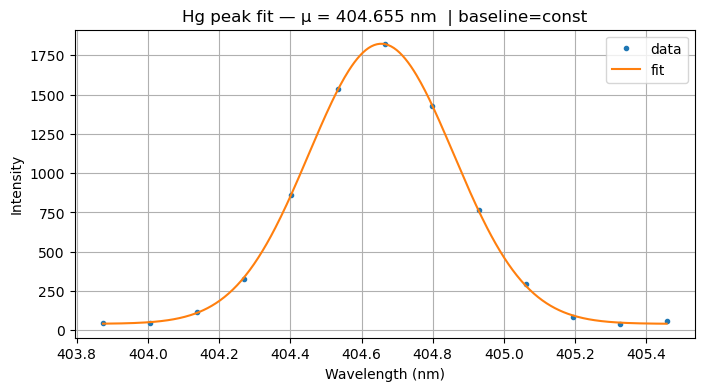

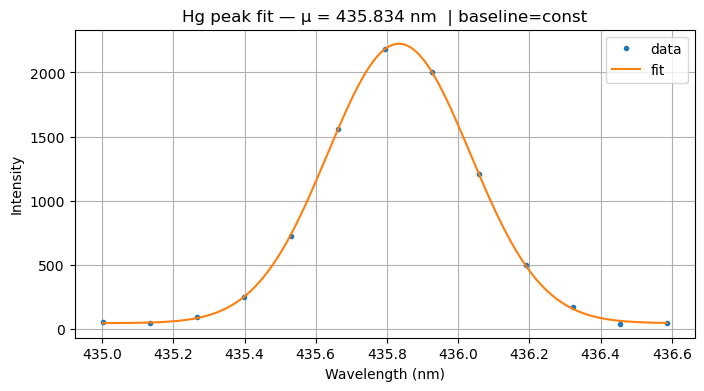

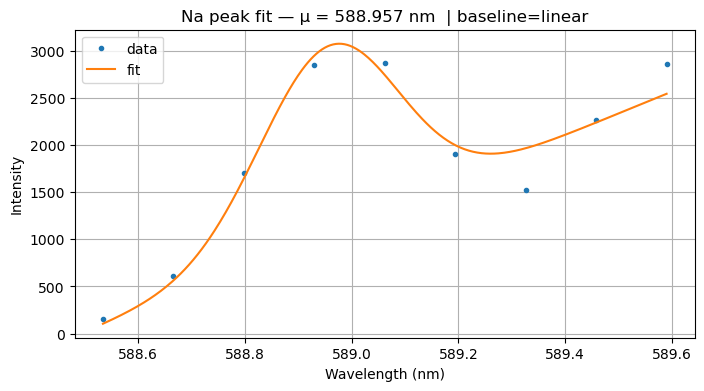

Fitted centers Hg: [404.65534213832973, 435.8336895302457, 546.0737837260708, 577.045222677088, 579.0656778227221]
Fitted centers Na: [588.9568054903199]


In [5]:
# ── Drop-in replacement: Peak-Fit mit wählbarem Untergrund + glatter Plot ──
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Modelle
def gauss_const(x, A, mu, sigma, B):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2)) + B

def gauss_linear(x, A, mu, sigma, B, C):
    # lineare Basis um mu zentriert (numerisch stabiler)
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2)) + (B + C*(x - mu))

def _init_linear_baseline(x, z):
    # einfache Startwerte für lineare Basis
    # fit auf die Randpunkte (untere 20% + obere 20% des Fensters)
    n = len(x)
    k = max(3, n // 5)
    xx = np.concatenate([x[:k], x[-k:]])
    yy = np.concatenate([z[:k], z[-k:]])
    p = np.polyfit(xx, yy, 1)  # y = p[0]*x + p[1]
    # in Parameterform B + C*(x - mu) umrechnen (mu kommt später)
    return p  # (slope, intercept)

def fit_peak(wl, y, center, window=0.8, baseline="const", xfit_points=400):
    """
    baseline: 'const' oder 'linear'
    window:   +/- nm um den Peak
    """
    mask = (wl > center - window) & (wl < center + window)
    x = wl[mask]; z = y[mask]
    if x.size < 5:
        return None, None, x, z, None, None, baseline

    # Startwerte
    A0 = float(z.max() - np.median(z))
    mu0 = float(x[np.argmax(z)])
    sigma0 = 0.20  # grober Startwert (nm)

    if baseline == "linear":
        slope, intercept = _init_linear_baseline(x, z)   # y ≈ slope*x + intercept
        # in B + C*(x - mu) umformen:  slope*x + intercept = (intercept + slope*mu) + slope*(x - mu)
        B0 = float(intercept + slope*mu0)
        C0 = float(slope)
        p0 = [A0, mu0, sigma0, B0, C0]
        model = gauss_linear
        bounds = (-np.inf, np.inf)
    else:
        B0 = float(np.median(z))
        p0 = [A0, mu0, sigma0, B0]
        model = gauss_const
        bounds = (-np.inf, np.inf)

    try:
        popt, pcov = curve_fit(model, x, z, p0=p0, maxfev=20000, bounds=bounds)
    except Exception:
        return None, None, x, z, None, None, baseline

    # glattes x-Raster zum Plotten
    xfit = np.linspace(x.min(), x.max(), xfit_points)
    yfit = model(xfit, *popt)
    return popt, pcov, x, z, xfit, yfit, baseline

# ── Fits neu berechnen ──
hg_fits = [fit_peak(hg_df["wavelength_nm"].values, hg_df["intensity"].values, c,
                    window=0.8, baseline="const")
           for c in hg_df["wavelength_nm"].values[hg_idx]]

# Na hat oft schrägen Untergrund → baseline='linear' und etwas engeres Fenster
na_fits = [fit_peak(na_df["wavelength_nm"].values, na_df["intensity"].values, c,
                    window=0.6, baseline="linear")
           for c in na_df["wavelength_nm"].values[na_idx]]

# ── Vorschau: erste Fits geplottet (glatt) ──
for label, fits in [("Hg", hg_fits), ("Na", na_fits)]:
    shown = 0
    for (popt, pcov, x, z, xfit, yfit, base) in fits:
        if popt is None: 
            continue
        plt.figure()
        plt.plot(x, z, ".", label="data")
        plt.plot(xfit, yfit, "-", label="fit")
        mu = popt[1]
        plt.title(f"{label} peak fit — μ = {mu:.3f} nm  | baseline={base}")
        plt.xlabel("Wavelength (nm)"); plt.ylabel("Intensity"); plt.legend(); plt.show()
        shown += 1
        if shown >= 2:
            break

# Zentren einsammeln
hg_centers = [p[0][1] for p in hg_fits if p[0] is not None]
na_centers = [p[0][1] for p in na_fits if p[0] is not None]
print("Fitted centers Hg:", hg_centers)
print("Fitted centers Na:", na_centers)



## 📏 Reference Lines & Matching
Select reference wavelengths from literature (approximate values below).  
> **TODO:** Confirm list and justify exclusions of problematic lines.


In [6]:

hg_ref = np.array([404.656, 435.833, 546.074, 577.045, 579.066])
na_ref = np.array([588.995, 589.592])

measured = np.array(sorted(hg_centers + na_centers))
reference = np.array(sorted(hg_ref.tolist() + na_ref.tolist()))

print("Measured centers (nm):", measured)
print("Reference lines (nm):", reference)

# TODO: If different lengths, manually select matching peaks:
# measured = measured[[...]]; reference = reference[[...]]


Measured centers (nm): [404.65534214 435.83368953 546.07378373 577.04522268 579.06567782
 588.95680549]
Reference lines (nm): [404.656 435.833 546.074 577.045 579.066 588.995 589.592]



## 🧮 Calibration Fit (Polynomial)
Map **pixel → wavelength** using a low-order polynomial (usually 2 or 3).  
Because synthetic data already have a wavelength axis, we simulate a pixel axis for demonstration.


Detected peaks: 6 | Reference lines: 7
Matched pairs: 6 (tol=0.6 nm)
  meas 404.655 nm ↔ ref 404.656 nm  (Δ=0.001 nm)
  meas 435.834 nm ↔ ref 435.833 nm  (Δ=0.001 nm)
  meas 546.074 nm ↔ ref 546.074 nm  (Δ=0.000 nm)
  meas 577.045 nm ↔ ref 577.045 nm  (Δ=0.000 nm)
  meas 579.066 nm ↔ ref 579.066 nm  (Δ=0.000 nm)
  meas 588.957 nm ↔ ref 588.995 nm  (Δ=0.038 nm)

Polynomial (deg=2) coefficients: [6.4537131248251475e-09, 0.13190176792092564, 380.0090471554863]
RMS residual [nm]: 0.0266


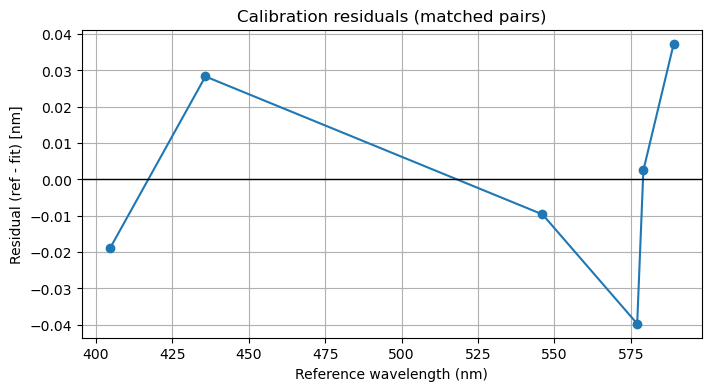

In [7]:

# ── Robust pairing gemessener Peaks ↔ Referenzlinien + Polyfit ──
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment

# 1) Gemessene Zentren (aus deinen Fits) und Referenzen sortieren
measured_all = np.array(sorted(hg_centers + na_centers))      # aus deinen Fits
reference_all = np.array(sorted([404.656, 435.833, 546.074, 577.045, 579.066, 588.995, 589.592]))

print(f"Detected peaks: {len(measured_all)} | Reference lines: {len(reference_all)}")

# 2) Optimales Matching (min |Delta lambda|) + Toleranzfilter
def pair_lines(measured, reference, tol_nm=0.6):
    if measured.size == 0 or reference.size == 0:
        return np.array([]), np.array([])

    C = np.abs(measured[:, None] - reference[None, :])  # Kostenmatrix
    row_ind, col_ind = linear_sum_assignment(C)         # ungarische Zuordnung
    diffs = C[row_ind, col_ind]

    # Nur Paare übernehmen, die innerhalb der Toleranz liegen
    keep = diffs <= tol_nm
    meas_sel = measured[row_ind[keep]]
    ref_sel  = reference[col_ind[keep]]
    diffs_sel = diffs[keep]
    return meas_sel, ref_sel, diffs_sel

meas_sel, ref_sel, diffs_sel = pair_lines(measured_all, reference_all, tol_nm=0.6)

print(f"Matched pairs: {len(meas_sel)} (tol=0.6 nm)")
for m, r, d in zip(meas_sel, ref_sel, diffs_sel):
    print(f"  meas {m:.3f} nm ↔ ref {r:.3f} nm  (Δ={d:.3f} nm)")

if meas_sel.size < 3:
    raise ValueError("Zu wenige gematchte Linien für eine stabile Kalibration. "
                     "Toleranz prüfen, Peaks/Referenzen anpassen oder zusätzliche Linien verwenden.")

# 3) Pixelpositionen zu den gemessenen Wellenlängen bestimmen
def nearest_pixel_for_wavelength(wl_axis, centers):
    return np.array([np.argmin(np.abs(wl_axis - c)) for c in centers], dtype=int)

wl_axis = hg_df["wavelength_nm"].values  # dein Spektralachsvektor
px = nearest_pixel_for_wavelength(wl_axis, meas_sel)

# 4) Polyfit (nur mit den gematchten Paaren!)
order = 2  # ggf. 3 testen und Residuen vergleichen
coeffs = np.polyfit(px, ref_sel, deg=order)
poly = np.poly1d(coeffs)

wl_fit = poly(px)
residuals = ref_sel - wl_fit
rms = float(np.sqrt(np.mean(residuals**2)))

print(f"\nPolynomial (deg={order}) coefficients:", coeffs.tolist())
print(f"RMS residual [nm]: {rms:.4f}")

# 5) Residuenplot
plt.figure()
plt.plot(ref_sel, residuals, 'o-')
plt.axhline(0, color='k', lw=1)
plt.xlabel("Reference wavelength (nm)")
plt.ylabel("Residual (ref - fit) [nm]")
plt.title("Calibration residuals (matched pairs)")
plt.show()


### 📊 Interpretation: Calibration Residuals

The *residual plot* does **not** show the calibration curve itself — it shows how well the fitted
polynomial describes the measured reference lines.

Each point represents one spectral line used for calibration:

$$
\text{Residual}_i = \lambda_{\mathrm{ref},i} - \lambda_{\mathrm{fit}}(p_i)
$$

where  
- $ \lambda_{\mathrm{ref},i} $  die Tabellen-Wellenlänge der Linie ist  
- $ \lambda_{\mathrm{fit}}(p_i) $  die von der Kalibrationsfunktion vorhergesagte Wellenlänge am Pixel $p_i$ ist


---

#### 🔎 What to look for
| Residual Pattern | Interpretation |
|------------------|----------------|
| Random scatter around 0 | ✅ Calibration fits well (only random noise) |
| Curved or U-shaped trend | 🔧 Polynomial order too low — add one more term |
| Linear drift (all positive/negative) | ⚠️ Systematic offset or wrong line pairing |
| Single outlier | ❌ Misidentified or blended peak |

---

A good calibration typically yields residuals within **±0.1 nm**  
(≈ 2–4 cm⁻¹ uncertainty in Raman shift at 532 nm excitation).

This plot is therefore a **diagnostic tool** — it validates that your wavelength-pixel model is accurate and unbiased across the spectrum.



## 📉 Uncertainty & Model Choice (Discussion)
- Compare polynomial **order 2 vs 3** (and 1 as baseline).  
- Quantify RMS residuals and inspect **systematic trends**.  
- Discuss how calibration uncertainty affects **Raman shift** errors (cm⁻¹).  
- **TODO:** Repeat with your real data and document the chosen model.



## ✅ Your Turn — Replace with Real Data (TODO)
1. Export **raw spectra** as CSV from OceanView.  
2. Load your files below (update the paths).  
3. Re-run detection, fitting, and calibration.  
4. Save your coefficients for Step 3 and Step 4.


In [ ]:

# TODO: Load your real lamp spectra here
# real_hg = pd.read_csv("../05_Data/calibration/Hg_reference.csv")
# real_na = pd.read_csv("../05_Data/calibration/Na_reference.csv")
# display(real_hg.head()); display(real_na.head())



## 💾 Save Calibration Parameters
Store the polynomial coefficients and metadata for reuse.


In [ ]:

import json
from pathlib import Path

calib = {
    "model": "poly",
    "order": int(order),
    "coefficients": [float(c) for c in coeffs],
    "reference_lines_nm": [float(x) for x in reference],
    "notes": "Replace with real-data fit before use."
}

out_path = Path("../05_Data/calibration/calibration_model_example.json")
out_path.parent.mkdir(parents=True, exist_ok=True)
with open(out_path, "w") as f:
    json.dump(calib, f, indent=2)
print("Saved calibration parameters to:", out_path.resolve())



---

### 🔗 Navigation
- Back to guide: [`01_Experiment_Guide/step2_calibration.md`](../01_Experiment_Guide/step2_calibration.md)  
- Next analysis: [`raman_spectra_analysis.ipynb`](raman_spectra_analysis.ipynb)
